# IOT Cats vs Dogs CNN Classification Training Script

# Step 1. Check if CUDA Is Enabled

In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Is CUDA available:", tf.test.is_built_with_cuda())
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Is CUDA available: True
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Step 2: Counting and Analyzing the Data


In [2]:
import os

def count_images(base_path, folder_name):
    path = os.path.join(base_path, folder_name)
    animal_folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    
    image_counts = {}
    
    for animal in animal_folders:
        animal_folder_path = os.path.join(path, animal)
        images = [img for img in os.listdir(animal_folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        image_counts[animal] = len(images)
    
    return image_counts

# Define paths
base_directory = 'Data'
train_folder = 'train'
test_folder = 'test'

# Get image counts
train_image_counts = count_images(base_directory, train_folder)
test_image_counts = count_images(base_directory, test_folder)

# Display the counts and calculate percentages
print("Image distribution across train and test folders:")
for animal in train_image_counts:
    total_images = train_image_counts[animal] + (test_image_counts[animal] if animal in test_image_counts else 0)
    test_percentage = (test_image_counts[animal] / total_images * 100) if animal in test_image_counts else 0
    print(f"{animal}: Train = {train_image_counts[animal]}, Test = {test_image_counts.get(animal, 0)}, "
          f"Test % = {test_percentage:.2f}%")

Image distribution across train and test folders:
Cats: Train = 500, Test = 125, Test % = 20.00%
Dogs: Train = 500, Test = 125, Test % = 20.00%


# Step 3: Set Up Data Augmentation and Data Generators


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the path to your dataset
base_dir = 'Data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Set up data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=40,     # Random rotations
    width_shift_range=0.2, # Random horizontal shifts
    height_shift_range=0.2,# Random vertical shifts
    shear_range=0.2,       # Shear transformations
    zoom_range=0.2,        # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    fill_mode='nearest'    # Strategy for filling newly created pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for testing data

# Prepare data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical'  # Multi-class labels
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1000 images belonging to 2 classes.
Found 250 images belonging to 2 classes.


# 4. Visualizing Augmented Images


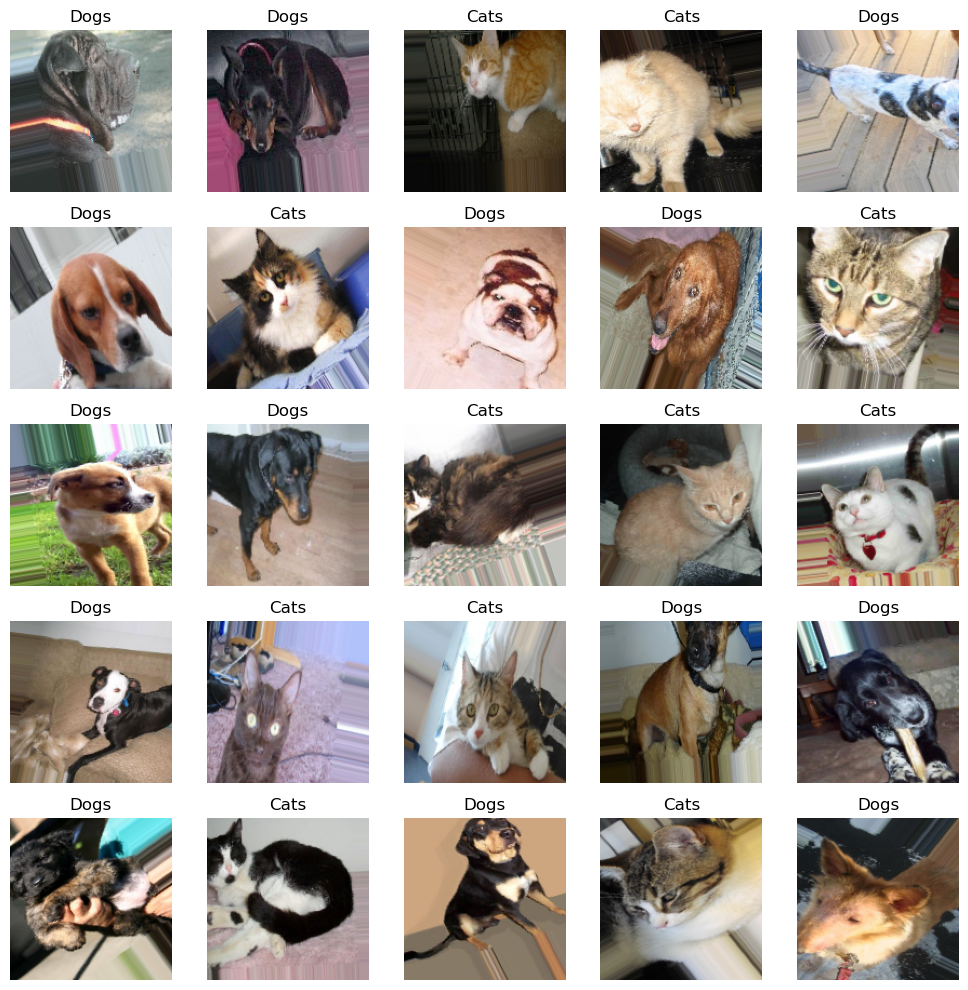

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot images in a 5x5 grid with labels
def plot_images(images_arr, labels_arr):
    fig, axes = plt.subplots(5, 5, figsize=(10, 10))  # Increase the subplot size to better fit labels
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)
    plt.tight_layout()
    plt.show()

# Ensure sufficient images are loaded to fill the grid
images = []
labels = []
for _ in range(5):  # Get 5 batches to have a variety; each batch typically has 32 images
    imgs, lbls = next(train_generator)
    images.extend(imgs)
    labels.extend(lbls)

# Ensure you have at least 25 images; if not, reduce the number or increase batch retrieval
if len(images) >= 25:
    # Choose 25 images randomly to display
    indices = np.random.choice(range(len(images)), 25, replace=False)
    selected_images = np.array(images)[indices]
    selected_labels = np.array(labels)[indices]

    # Convert one-hot labels to class names
    class_names = list(train_generator.class_indices.keys())  # Get class names from the generator
    selected_labels = [class_names[np.argmax(label)] for label in selected_labels]

    # Plot the selected images and their labels
    plot_images(selected_images, selected_labels)
else:
    print("Not enough images loaded to display. Try increasing the number of batches retrieved.")

# Step 5: Defining the CNN Model Architecture


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the model
model = Sequential([
    # First convolutional layer
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    # Second convolutional layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Third convolutional layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Fourth convolutional layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    # Flatten the results to feed into a dense layer
    Flatten(),
    # 512 neuron hidden layer
    Dense(512, activation='relu'),
    Dropout(0.5),
    # Output layer with a single neuron for each class
    Dense(len(train_generator.class_indices), activation='softmax')
])

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 17, 17, 128)     

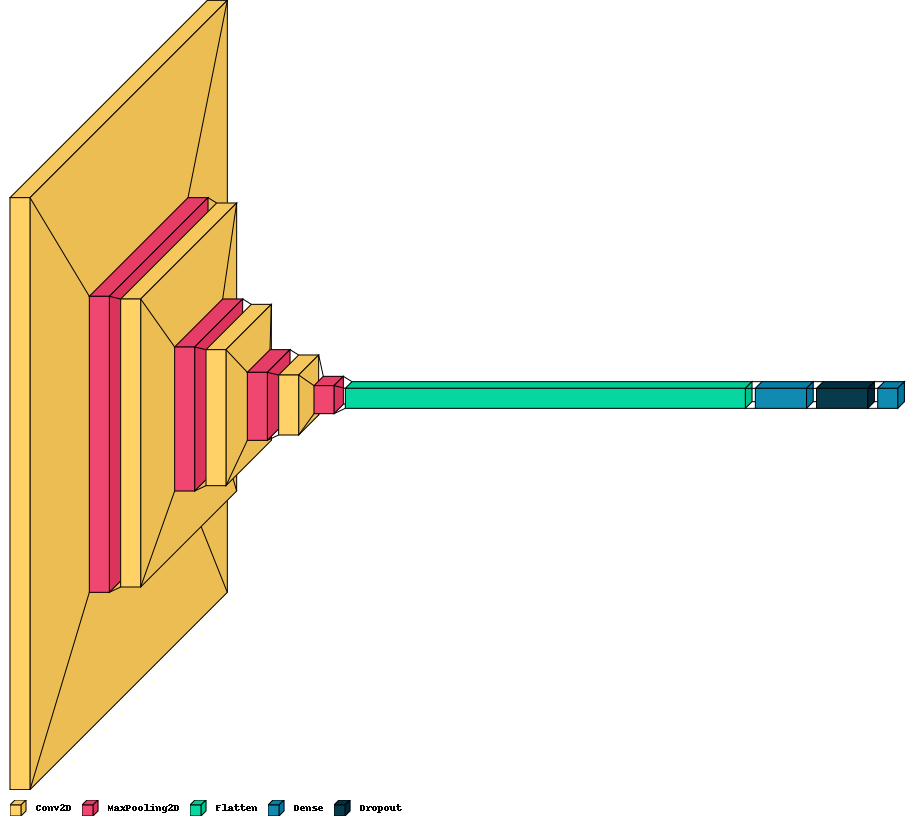

In [44]:
from PIL import ImageFont
import visualkeras

# Generate the model visual with a custom font
visualkeras.layered_view(model, legend=True)

# Step 6. Compile the Model


In [45]:
from tensorflow.keras.optimizers import RMSprop

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

# Step 7: Train the CNN Model


## Code to Train the Model and Plot Performance


Epoch 1/30
32/32 [==============================] - 6s 156ms/step - loss: 0.8808 - accuracy: 0.5070 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/30
32/32 [==============================] - 5s 154ms/step - loss: 0.7045 - accuracy: 0.5130 - val_loss: 0.6920 - val_accuracy: 0.5080
Epoch 3/30
32/32 [==============================] - 5s 152ms/step - loss: 0.6891 - accuracy: 0.5480 - val_loss: 0.6916 - val_accuracy: 0.5200
Epoch 4/30
32/32 [==============================] - 5s 149ms/step - loss: 0.6897 - accuracy: 0.5440 - val_loss: 0.6904 - val_accuracy: 0.5080
Epoch 5/30
32/32 [==============================] - 5s 150ms/step - loss: 0.6885 - accuracy: 0.5400 - val_loss: 0.6978 - val_accuracy: 0.4960
Epoch 6/30
32/32 [==============================] - 5s 148ms/step - loss: 0.6958 - accuracy: 0.5450 - val_loss: 0.6972 - val_accuracy: 0.5080
Epoch 7/30
32/32 [==============================] - 5s 150ms/step - loss: 0.6863 - accuracy: 0.5210 - val_loss: 0.6910 - val_accuracy: 0.5160
Epoch 

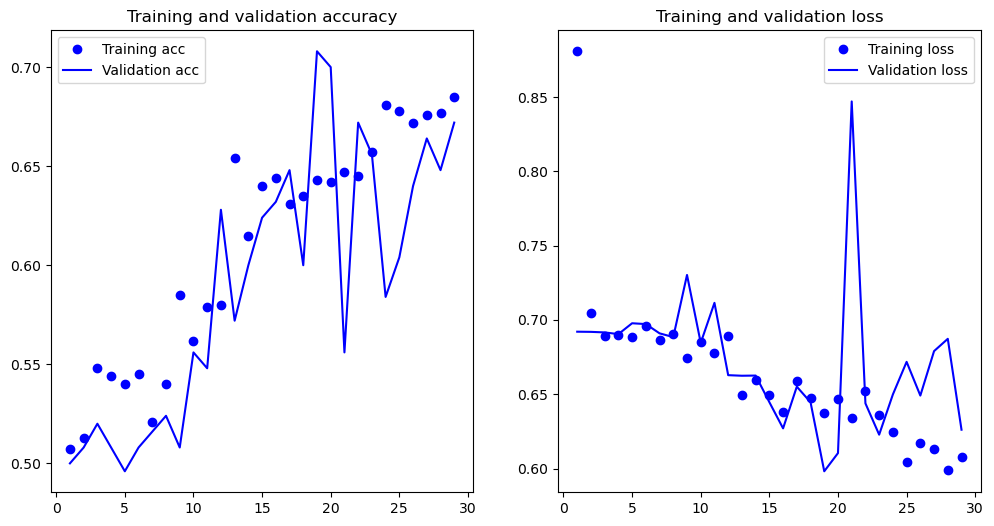

In [46]:
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping

# Define the Early Stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Fit the model with Early Stopping
history = model.fit(
    train_generator,
    epochs=30,  # Maximum number of epochs (might stop earlier)
    validation_data=test_generator,
    verbose=1,
    callbacks=[early_stopping]  # Include the Early Stopping callback
)

# Function to plot training and validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

# Call the function to plot the training and validation accuracy and loss
plot_training_history(history)

## Save Model

In [47]:
# Save the model
model.save('cats_dogs_classifier_model.h5')  # Saves the model in HDF5 format

# Step 8: Load and Use the Model for Predictions


In [50]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import os
import random

# Load the saved model (make sure the name corresponds to your Cats vs Dogs model)
model = load_model('cats_dogs_classifier_model.h5')  # Update this to the correct model file name

# Function to load and prepare the image
def load_and_prepare_image(file_path):
    img = image.load_img(file_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return img_array_expanded_dims / 255.0

# Base directory for test images
base_dir = 'Data/test'

# Get class directories
class_directories = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# List to store class labels
class_labels = ['Cats', 'Dogs']  # Ensure these match the labels used during training

# Iterate over each class directory
for class_dir in class_directories:
    # Get all files in directory
    files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    # Select a random file
    random_file = random.choice(files)
    
    # Prepare the image
    prepared_image = load_and_prepare_image(random_file)
    
    # Make a prediction
    predictions = model.predict(prepared_image)
    predicted_class_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_index] * 100  # multiply by 100 to convert to percentage
    
    # Get class name from directory
    class_name = os.path.basename(class_dir)
    
    # Display the prediction and confidence
    print(f"Actual class: {class_name} - Predicted class: {class_labels[predicted_class_index]} with Confidence: {confidence:.2f}%")

1/1 [==============================] - 0s 376ms/step
Actual class: Cats - Predicted class: Cats with Confidence: 65.48%
1/1 [==============================] - 0s 17ms/step
Actual class: Dogs - Predicted class: Dogs with Confidence: 55.19%
